Figuring out how to use PAM

In [174]:
import os
from copy import deepcopy

import acbm

import numpy as np
import pandas as pd
import geopandas as gpd
import pam
from pam import read, write
from pam.activity import Activity, Leg, Plan
from pam.location import Location
from pam.planner.choice_location import DiscretionaryTripOD, DiscretionaryTrips
from pam.planner.od import ODFactory, ODMatrix
from pam.planner.utils_planner import get_trip_chains_either_anchor
from pam.plot.stats import plot_activity_times, plot_leg_times
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from prettytable import PrettyTable
from shapely.geometry import Point
from libpysal.weights import Queen


from acbm.preprocessing import nts_filter_by_year, add_location
from acbm.assigning.primary_select import select_facility

pd.set_option('display.max_columns', None)


# Load in the data

In [2]:
activity_chains = pd.read_parquet(
    acbm.root_path / "data/interim/matching/spc_with_nts_trips.parquet"
)
activity_chains = activity_chains[activity_chains["TravDay"] == 3]  # Wednesday


## Remove all people who don't start their day at home

In [169]:
activity_chains.head(20)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,E00059031
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,E00059031
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,E00059031
3,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,E00059031
4,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,2.0,2.0,0.568328,1.000000,E00059031
5,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,2.0,0.568328,1.000000,E00059031
6,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City

## Add OA21CD to the data

We will use it to select home locations using select_facility()

In [4]:
where_clause = "MSOA21NM LIKE '%Leeds%'"

boundaries = gpd.read_file(
    acbm.root_path / "data/external/boundaries/oa_england.geojson", where=where_clause
)

# convert boundaries to 4326
boundaries = boundaries.to_crs(epsg=4326)


# --- Assign activity home locations to boundaries zoning system

# Convert location column in activity_chains to spatial column
centroid_layer = pd.read_csv(
    acbm.root_path / "data/external/centroids/Output_Areas_Dec_2011_PWC_2022.csv"
)
activity_chains = add_location(
    activity_chains, "EPSG:27700", "EPSG:4326", centroid_layer, "OA11CD", "OA11CD"
)

# Convert the DataFrame into a GeoDataFrame, and assign a coordinate reference system (CRS)
activity_chains = gpd.GeoDataFrame(activity_chains, geometry="location")
activity_chains.crs = "EPSG:4326"  # I assume this is the crs


# remove index_right column from activity_chains if it exists
if "index_right" in activity_chains.columns:
    activity_chains = activity_chains.drop(columns="index_right")


# Spatial join to identify which polygons each point is in
activity_chains = gpd.sjoin(
    activity_chains, boundaries[["OA21CD", "geometry"]], how="left", predicate="within"
)
activity_chains = activity_chains.drop("index_right", axis=1)

2024-08-23 09:43:25,839 - DEBUG - Could not import boto3, continuing with reduced functionality.
2024-08-23 09:43:25,846 - DEBUG - GDAL_DATA found in environment.
2024-08-23 09:43:25,846 - DEBUG - PROJ_DATA found in environment.
2024-08-23 09:43:25,851 - DEBUG - GDAL_DATA found in environment.
2024-08-23 09:43:25,852 - DEBUG - PROJ_DATA found in environment.
2024-08-23 09:43:30,527 - DEBUG - GDAL_DATA found in environment.
2024-08-23 09:43:30,527 - DEBUG - PROJ_DATA found in environment.
2024-08-23 09:43:30,528 - DEBUG - Got coordinate system
2024-08-23 09:43:30,528 - DEBUG - Got coordinate system
2024-08-23 09:43:30,536 - DEBUG - Matched. confidence=100, c_code=b'27700', c_name=b'EPSG'
2024-08-23 09:43:30,536 - DEBUG - OLC_FASTSETNEXTBYINDEX: 0
2024-08-23 09:43:30,537 - DEBUG - OLC_FASTFEATURECOUNT: 0
2024-08-23 09:43:30,537 - DEBUG - Next index: 0
2024-08-23 09:43:30,538 - DEBUG - Next index: 1
2024-08-23 09:43:31,667 - DEBUG - Next index: 2
2024-08-23 09:43:31,668 - DEBUG - Next ind

In [5]:
# remove location column
activity_chains = activity_chains.drop(columns="location")

## Primary locations

In [6]:
activity_chains_edu = pd.read_pickle(
    acbm.root_path / "data/interim/assigning/activity_chains_education.pkl"
)

activity_chains_work = pd.read_pickle(
    acbm.root_path / "data/interim/assigning/activity_chains_work.pkl"
)


In [7]:
activity_chains_edu.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD,activity_id,activity_geom
0,201,89,2903217,E02002330,E00059031,"[199, 200, 201]",None,NaN,0,NaN,NaN,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,7,1,2.0,34166.520508,2,0,2,1,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2021004708,education_school,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,3.0,3.0,1.0,2.0,1.0,8.0,car,home,education,3.0,520.0,525.0,1.0,1.0,5.0,5.0,2.0,E00059030,0.568328,1.000000,POINT (-1.39680 53.93384),E00059031,160360912,POINT (-1.390539537152311 53.93323059983641)
1,612,283,2909651,E02002330,E00059012,"[610, 611, 612, 613]",None,NaN,0,NaN,NaN,E02002330_0284,1.0,NaN,6.0,True,5.0,1,1,8,1,3.0,0.000000,1,0,2,1,2,0,1,0,0,1,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,2.0,[2019000846.0],2,2019002010,education_school,2.019027e+09,2.019013e+09,2.019002e+09,2.019001e+09,2.019000e+09,3.0,3.0,1.0,2.0,1.0,7.0,car,home,education,3.0,NaN,NaN,2.5,2.5,12.0,12.0,2.0,E00059023,0.809313,1.008714,POINT (-1.38647 53.94082),E00059012,2409409,POINT (-1.389357834048406 53.9408016531483)
2,613,283,2905230,E02002330,E00059012,"[610, 611, 612, 613]",None,NaN,0,NaN,NaN,E02002330_0284,1.0,NaN,6.0,True,5.0,1,2,2,1,3.0,0.000000,1,0,2,1,2,0,1,0,0,1,E00059012,Urban city and town,C1,Urban,Urban City and Town,1,2,2.0,[2019000846.0],1,2019002011,education_kg,2.019027e+09,2.019013e+09,2.019002e+09,2.019001e+09,2.019000e+09,4.0,3.0,1.0,2.0,1.0,7.0,car,home,education,3.0,NaN,NaN,2.5,2.5,12.0,12.0,2.0,E00059023,0.809313,1.008714,POINT (-1.38647 53.94082),E00059012,1417642752,POINT (-1.390621436812582 53.94100084738917)
3,4550,2107,2912299,E02002330,E00059038,"[4548, 4549, 4550]",None,NaN,0,NaN,NaN,E02002330_2108,1.0,NaN,6.0,True,2.0,2,1,5,1,2.0,0.000000,1,0,2,1,1,0,0,0,0,1,E00059038,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2019003222,education_school,2.019043e+09,2.019021e+09,2.019003e+09,2.019001e+09,2.019000e+09,3.0,3.0,1.0,2.0,1.0,7.0,car,home,education,3.0,490.0,510.0,3.5,3.5,20.0,20.0,6.0,E00059036,1.179377,1.008714,POINT (-1.40113 53.92999),E00059038,24688425,POINT (-1.389512998190205 53.93069086875136)
4,5486,2499,2903909,E02002330,E00059022,"[5484, 5485, 5486]",None,NaN,0,NaN,NaN,E02002330_2500,1.0,NaN,6.0,True,1.0,2,2,15,1,1.0,4926.177246,1,0,2,1,1,0,1,0,1,2,E00059022,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2021000738.0, 2022002765.0, 2022003258.0]",3,2022007392,education_school,2.022083e+09,2.022044e+09,2.022007e+09,2.022003e+09,2.022001e+09,3.0,3.0,1.0,2.0,1.0,2.0,walk,home,education,3.0,485.0,505.0,1.0,1.0,20.0,20.0,3.0,E00059023,0.845366,1.000000,POINT (-1.39476 53.94100),E00059022,2409409,POINT (-1.389357834048406 53.9408016531483)
5,6310,2834,2901750,E02002330,E00059028,"[6308, 6309, 6310]",None,NaN,0,NaN,NaN,E02002330_2835,2.0,NaN,6.0,True,2.0,2,1,11,5,2.0,40131.613281,2,0,2,1,1,0,1,1,0,3,E00059028,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2021000738.0, 2022002765.0, 2022003258.0]",3,2022007392,education_school,2.022083e+09,2.022044e+09,2.022007e+09,2.022003e+09,2.022001e+09,3.0,3.0,1.0,2.0,1.0,2.0,walk,home,educat

In [8]:
# get all activity chains where dact is home
activity_chains_home = activity_chains[activity_chains["dact"] == "home"]
# get all activity chains where dact is not work or education
activity_chains_other = activity_chains[
    ~activity_chains["dact"].isin(["work", "education", "home"])
]


In [9]:
# Replace ozone and dzone with Na in activity_chains_other. They are incorrect and will be populated later
activity_chains_other.loc[:, ["ozone", "dzone"]] = np.nan
activity_chains_other.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,NaN,NaN,0.633716,1.115053,E00059031
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,NaN,NaN,0.639694,1.125570,E00059031
6,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,1.0,2.0,1.0,5.0,car,home,escort,5.0,765.0,840.0,1.0,1.0,75.0,45.0,NaN,NaN,0.646775,1.138030,E00059031
12,313,139,2911885,E02002330,E00059045,"[312, 313]",N,80.0,1,22676.896484,11.786329,E02002330_0140,1.0,NaN,6.0,True,1.0,1,1,64,3,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002995,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,5.0,car,home,escort,5.0,400.0,401.0,0.3,0.3,1.0,1.0,NaN,NaN,0.961816,1.138030,E00059045
14,313,139,2911885,E02002330,E00059045,"[312, 313]",N,80.0,1,22676.896484,11.786329,E02002330_0140,1.0,NaN,6.0,True,1.0,1,1,64,3,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002995,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,work,escort,5.0,1300.0,1322.0,13.0,13.0,22.0,22.0,NaN,NaN,0.961816,1.138030,E00059045
16,425,197,2901553,E02002330,E00059023,"[425, 426]",C,29.0,6,NaN,NaN,E02002330_0198,1.0,NaN,6.0,True,1.0,1,1,59,1,2.0,0.000000,1,1,1,0,1,0,0,0,0,1,E00059023,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001746.0, 2019001081.0, 2019001177.0, 201...",8,2022004472,education_university,2.022050e+09,2.022027e+09,2.022004e+09,2.022002e+09,2.022000e+09,1.0,3.0,1.0,2.0,1.0,5.0,car,home,other,7.0,540.0,554.0,2.7,2.7,14.0,14.0,NaN,NaN,1.356007,1.003426,E00059023
18,425,197,2901553,E02002330,E00059023,"[425, 426]",C,29.0,6,NaN,NaN,E02002330_0198,1.0,NaN,6.0,True,1.0,1,1,59,1,2.0,0.000000,1,1,1,0,1,0,0,0,0,1,E00059023,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019001746.0, 2019001081.0, 2

In [10]:
(activity_chains.shape[0], 
 activity_chains_edu.shape[0], 
 activity_chains_work.shape[0], 
 activity_chains_home.shape[0], 
 activity_chains_other.shape[0])

(15811, 411, 1806, 6849, 6745)

In [11]:
activity_chains["dact"].value_counts()

dact
home         6849
other        2621
work         1806
escort       1762
shop         1281
visit         896
education     411
medical       185
Name: count, dtype: int64

# Add home locations


In [12]:
# osm data
osm_data_gdf = gpd.read_parquet(
    acbm.root_path / "data/external/boundaries/west-yorkshire_epsg_4326.parquet"
)

# get rows in osm_data_gdf where activities includes home

osm_data_gdf = osm_data_gdf[osm_data_gdf["activities"].str.contains("home")]
osm_data_gdf

# spatial join to identify which zone each point in osm_data is in
osm_data_gdf = gpd.sjoin(
    osm_data_gdf, boundaries[["OA21CD", "geometry"]], how="inner", predicate="within"
)

osm_data_gdf.head(10)

,id,activities,geometry,units,levels,area,floor_area,distance_to_nearest_transit,distance_to_nearest_shop,distance_to_nearest_medical,index_right,OA21CD
1,20621535,home,POINT (-1.56566 53.81375),1.0,2.0,0,0.0,198.493258,108.072976,255.853754,851,E00057657
2,21591858,home,POINT (-1.63279 53.87138),1.0,2.0,0,0.0,969.484065,509.809989,2318.285507,557,E00057349
5,27411630,home,POINT (-1.72353 53.90655),1.0,2.0,0,0.0,216.265895,986.041911,1716.667311,1524,E00058367
7,27470976,home,POINT (-1.56251 53.90203),1.0,2.0,0,0.0,873.984192,1799.502624,3250.842461,1478,E00058319
117,243857658,home,POINT (-1.58420 53.82091),1.0,2.0,0,0.0,254.519273,207.974705,391.618763,834,E00057637
215,263905389,home,POINT (-1.58480 53.83411),1.0,2.0,0,0.0,18.165010,538.231938,947.117436,2070,E00058957
233,266347353,home,POINT (-1.59132 53.86960),1.0,2.0,0,0.0,239.833745,330.022370,1799.256632,2475,E00170889
436,297118275,home,POINT (-1.65174 53.79927),1.0,2.0,0,0.0,78.022954,40.506960,23.413135,1632,E00058477
549,304609832,home,POINT (-1.62587 53.80985),1.0,2.0,0,0.0,46.651413,103.570196,161.971263,144,E00056906
623,317087655,home,POINT (-1.53952 53.79314),1.0,2.0,0,0.0,198.799706,55.563040,250.884104,2482,E00187029


## Calculate a home location only once per household

In [13]:
# Keep one row per household and select only household and OA21CD columns
activity_chains_home_hh = activity_chains_home.drop_duplicates(subset=["household"])
activity_chains_home_hh = activity_chains_home_hh[["household", "dact", "OA21CD"]]

In [14]:
activity_chains_home_hh

,household,dact,OA21CD
1,89,home,E00059031
11,139,home,E00059045
17,197,home,E00059023
21,283,home,E00059012
38,342,home,E00059033
...,...,...,...
15790,334049,home,E00187098
15792,334172,home,E00057789
15794,334223,home,E00170040
15799,334249,home,E00170267


## Get the home location

In [15]:
zone_neighbors = Queen.from_dataframe(boundaries, ids="OA21CD").neighbors


In [16]:
# apply the function to a row in activity_chains_ex
# TODO: edit function so that we have replacement = false option. We don't want to assign different households to the same home
activity_chains_home_hh[["activity_id", "activity_geom"]] = activity_chains_home_hh.apply(
    lambda row: select_facility(
        row=row,
        facilities_gdf=osm_data_gdf,
        row_destination_zone_col="OA21CD",
        row_activity_type_col="dact",
        gdf_facility_zone_col="OA21CD",
        gdf_facility_type_col="activities",
        gdf_sample_col="floor_area",
        neighboring_zones=zone_neighbors,
    ),
    axis=1,
)

2024-08-23 09:43:42,957 - assigning_primary_locations - INFO - Activity 1: Found 182 matching facilities in zone E00059031
2024-08-23 09:43:42,957 - INFO - Activity 1: Found 182 matching facilities in zone E00059031
2024-08-23 09:43:42,960 - assigning_primary_locations - INFO - Activity 1: Sampled facility based on floor area)
2024-08-23 09:43:42,960 - INFO - Activity 1: Sampled facility based on floor area)
2024-08-23 09:43:42,975 - assigning_primary_locations - INFO - Activity 11: Found 124 matching facilities in zone E00059045
2024-08-23 09:43:42,975 - INFO - Activity 11: Found 124 matching facilities in zone E00059045
2024-08-23 09:43:42,978 - assigning_primary_locations - INFO - Activity 11: Sampled facility based on floor area)
2024-08-23 09:43:42,978 - INFO - Activity 11: Sampled facility based on floor area)
2024-08-23 09:43:42,992 - assigning_primary_locations - INFO - Activity 17: Found 124 matching facilities in zone E00059023
2024-08-23 09:43:42,992 - INFO - Activity 17: Fo

In [17]:
activity_chains_home_hh.head(5)

,household,dact,OA21CD,activity_id,activity_geom
1,89,home,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
11,139,home,E00059045,1750466294,POINT (-1.400714718334167 53.92845640677041)
17,197,home,E00059023,1730050358,POINT (-1.392682575589612 53.93972004752036)
21,283,home,E00059012,1786588134,POINT (-1.387632388285015 53.94249418355444)
38,342,home,E00059033,1685619020,POINT (-1.40647626763714 53.93362421245939)


## Merge home locations back onto activity_chains_home

In [18]:
# join activity_chains_home_hh onto activity_chains_home based on household column
activity_chains_home = activity_chains_home.merge(
    activity_chains_home_hh[["household", "activity_id", "activity_geom"]],
    on="household",
    how="left",
)

activity_chains_home.head(5)


,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD,activity_id,activity_geom
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,2.0,0.568328,1.000000,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
3,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,5.0,car,escort,home,5.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,2.0,0.646775,1.138030,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
4,201,89,2903217,E02002330,E00059031,"[199, 200, 201]",None,NaN,0,NaN,NaN,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,7,1,2.0,34166.520508,2,0,2,1,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2021004708,education_school,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,3.0,3.0,2.0,2.0,1.0,7.0,car,medical,home,6.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,2.0,0.646775,1.138030,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)


In [19]:
# replace dzone column with OA21CD
activity_chains_home["dzone"] = activity_chains_home["OA21CD"]
activity_chains_home.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD,activity_id,activity_geom
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,E00059031,0.633716,1.115053,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,E00059031,0.639694,1.125570,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,E00059031,0.568328,1.000000,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
3,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,5.0,car,escort,home,5.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,E00059031,0.646775,1.138030,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
4,201,89,2903217,E02002330,E00059031,"[199, 200, 201]",None,NaN,0,NaN,NaN,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,7,1,2.0,34166.520508,2,0,2,1,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2021004708,education_school,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,3.0,3.0,2.0,2.0,1.0,7.0,car,medical,home,6.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,E00059031,0.646775,1.138030,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
5,312,139,2911320,E02002330,E00059045,"[312, 313]",Q,86.0,6,NaN,NaN,E02002330_0140,1.0,NaN,6.0,True,1.0,1,2,64,1,2.0,22676.896484,1,1,2,0,0,0,0,1,0,3,E00059045,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",9,2021002994,education_university,2.021024e+09,2.021020e+09,2.021003e+09,2.021001e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,7.0,ca

# Combine all dataframes

In [20]:
# merge the three dataframes
activity_chains_all = pd.concat([activity_chains_edu, 
                                 activity_chains_work, 
                                 activity_chains_home,
                                 activity_chains_other])
# sort by houshold_id, individual_id, and sequence
activity_chains_all = activity_chains_all.sort_values(by=["household", "id", "seq"])
activity_chains_all.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD,activity_id,activity_geom
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,NaN,NaN,0.633716,1.115053,None,E00059031,NaN,NaN
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,E00059031,0.633716,1.115053,None,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,NaN,NaN,0.639694,1.125570,None,E00059031,NaN,NaN
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,E00059031,0.639694,1.125570,None,E00059031,1735589254,POINT (-1.394696580252288 53.93492490085313)
10,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,2.0,E00058564,0.568328,1.000000,None,NaN,1955094120,POINT (-1.49656225379334 53.78439183373149)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2

## Remove all people who don't start their day at home

They will raise an error in PAM

In [21]:
# group by id column, and remove all groups where oact is not home in the first row
activity_chains_all = activity_chains_all.sort_values(by=["household", "id", "seq"])

print(f'PRE-FILTERING: Number of activities: {activity_chains_all.shape[0]}, number of individuals: {activity_chains_all["id"].nunique()}')
total_activities = activity_chains_all.shape[0]

activity_chains_all = activity_chains_all.groupby("id").filter(lambda x: x.iloc[0]["oact"] == "home")

print(f'POST-FILTERING: Number of activities: {activity_chains_all.shape[0]}, number of individuals: {activity_chains_all["id"].nunique()}')

removed_activities = total_activities - activity_chains_all.shape[0]
percentage_removed = (removed_activities / total_activities) * 100
print(f'Removed {removed_activities} activities, which is {percentage_removed:.2f}% of the total activities')

PRE-FILTERING: Number of activities: 15811, number of individuals: 5630
POST-FILTERING: Number of activities: 15164, number of individuals: 5357
Removed 647 activities, which is 4.09% of the total activities


## Check modes

We can only use modes that we have travel times for

In [22]:
activity_chains_all["mode"].value_counts()

mode
car           11515
pt             1674
walk           1588
bike            333
motorcycle       54
Name: count, dtype: int64

In [23]:
# replace motorcyle with car
activity_chains_all["mode"] = activity_chains_all["mode"].replace("motorcycle", "car")

## Populate ozone column for primary activities

Our dfs have populated the `dzone`, `activity_id`, and `activity_geom` columns for rows where `dact` matches: [home, work, education]. 
For each person, we look at rows where the `ozone` is one of [home, work, education], and populate the `ozone`, `origin_id`, `origin_geom` columns for the primary activity with the same value.

TODO: rename `activity_id` to `destination_id` and `activity_geom` to `destination_geom`

In [24]:
# Step 1: Create dictionaries to map each id to their activity_geom, activity_id, and dzone for each activity type
activity_types = ["home", "education", "work"]
activity_geom_dict = {}
activity_id_dict = {}
dzone_dict = {}

for activity in activity_types:
    filtered_df = activity_chains_all[
        (activity_chains_all["dact"] == activity) & (activity_chains_all["activity_geom"].notnull())
    ]
    activity_geom_dict[activity] = filtered_df.set_index("id")["activity_geom"].to_dict()
    activity_id_dict[activity] = filtered_df.set_index("id")["activity_id"].to_dict()
    dzone_dict[activity] = filtered_df.set_index("id")["dzone"].to_dict()

# Step 2: Populate the origin_geom, origin_id, and ozone columns based on the oact value
def get_origin_geom(row):
    if row["oact"] in activity_geom_dict and row["id"] in activity_geom_dict[row["oact"]]:
        return activity_geom_dict[row["oact"]][row["id"]]
    return None

def get_origin_id(row):
    if row["oact"] in activity_id_dict and row["id"] in activity_id_dict[row["oact"]]:
        return activity_id_dict[row["oact"]][row["id"]]
    return None

def get_ozone(row):
    if row["oact"] in dzone_dict and row["id"] in dzone_dict[row["oact"]]:
        return dzone_dict[row["oact"]][row["id"]]
    return np.nan

activity_chains_all = activity_chains_all.copy()
activity_chains_all["origin_geom"] = activity_chains_all.apply(get_origin_geom, axis=1)
activity_chains_all["origin_id"] = activity_chains_all.apply(get_origin_id, axis=1)
activity_chains_all["ozone"] = activity_chains_all.apply(get_ozone, axis=1)

In [25]:
activity_chains_all = activity_chains_all[["id", "household", "nts_ind_id", "nts_hh_id", "age_years", 
                                           "oact", "dact", "TripTotalTime", "TripDisIncSW", "seq", "mode", "tst", "tet", 
                                           "ozone", "dzone", "origin_id", "origin_geom", "activity_id", "activity_geom"]]

activity_chains_all.head(10)

,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,ozone,dzone,origin_id,origin_geom,activity_id,activity_geom
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,other,45.0,6.0,1.0,walk,600.0,645.0,E00059031,NaN,1735589254,POINT (-1.39470 53.93492),NaN,NaN
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,other,home,45.0,6.0,2.0,walk,645.0,690.0,NaN,E00059031,None,None,1735589254,POINT (-1.394696580252288 53.93492490085313)
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,shop,10.0,1.0,3.0,car,720.0,730.0,E00059031,NaN,1735589254,POINT (-1.39470 53.93492),NaN,NaN
1,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,shop,home,10.0,1.0,4.0,car,765.0,775.0,NaN,E00059031,None,None,1735589254,POINT (-1.394696580252288 53.93492490085313)
10,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,work,20.0,13.0,5.0,car,810.0,830.0,E00059031,E00058564,1735589254,POINT (-1.39470 53.93492),1955094120,POINT (-1.49656225379334 53.78439183373149)
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,work,home,30.0,13.0,6.0,car,1230.0,1260.0,E00058564,E00059031,1955094120,POINT (-1.49656 53.78439),1735589254,POINT (-1.394696580252288 53.93492490085313)
6,200,89,2021004706,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",38,home,escort,75.0,1.0,1.0,car,765.0,840.0,E00059031,NaN,1735589254,POINT (-1.39470 53.93492),NaN,NaN
3,200,89,2021004706,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",38,escort,home,20.0,1.0,2.0,car,930.0,950.0,NaN,E00059031,None,None,1735589254,POINT (-1.394696580252288 53.93492490085313)
0,201,89,2021004708,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,home,education,5.0,1.0,1.0,car,520.0,525.0,E00059031,E00059030,1735589254,POINT (-1.39470 53.93492),160360912,POINT (-1.390539537152311 53.93323059983641)
4,201,89,2021004708,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,medical,home,20.0,1.0,2.0,car,930.0,950.0,NaN,E00059031,None,None,1735589254,POINT (-1.394696580252288 53.93492490085313)


### PAM needs a hzone column. Add it

In [26]:

# Merge the DataFrames on 'household_id' from activity_chains and 'house_id' from activity_chains_home_hh
activity_chains_all = activity_chains_all.merge(activity_chains_home_hh[['household', 'OA21CD']], on='household', how ='left')

# Rename the 'OA21CD' column to 'hzone'
activity_chains_all.rename(columns={'OA21CD': 'hzone'}, inplace=True)

activity_chains_all.head(5)

,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,ozone,dzone,origin_id,origin_geom,activity_id,activity_geom,hzone
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,other,45.0,6.0,1.0,walk,600.0,645.0,E00059031,NaN,1735589254,POINT (-1.39470 53.93492),NaN,NaN,E00059031
1,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,other,home,45.0,6.0,2.0,walk,645.0,690.0,NaN,E00059031,None,None,1735589254,POINT (-1.394696580252288 53.93492490085313),E00059031
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,shop,10.0,1.0,3.0,car,720.0,730.0,E00059031,NaN,1735589254,POINT (-1.39470 53.93492),NaN,NaN,E00059031
3,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,shop,home,10.0,1.0,4.0,car,765.0,775.0,NaN,E00059031,None,None,1735589254,POINT (-1.394696580252288 53.93492490085313),E00059031
4,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,work,20.0,13.0,5.0,car,810.0,830.0,E00059031,E00058564,1735589254,POINT (-1.39470 53.93492),1955094120,POINT (-1.49656225379334 53.78439183373149),E00059031


### Add home locations for all rows where oact = "home"

I was populating home data based on its existence in the dact column. Some entries are outliers which were missed by this logic.

See :

- activity_chains_all[activity_chains_all["id"] == 808]
- activity_chains_all[activity_chains_all["id"] == 1994]

This adds home data for oact = home (MESSY: REDO)

In [27]:
# activity_chains_all[activity_chains_all["id"] == 808]
# activity_chains_all[activity_chains_all["id"] == 1994]


In [28]:
# Rename columns then select necessary ones 
activity_chains_home_hh_selected = activity_chains_home_hh.rename(columns={
    'OA21CD': 'ozone', 
    'activity_id': 'origin_id', 
    'activity_geom': 'origin_geom'
})[['household', 'ozone', 'origin_id', 'origin_geom']]

# Merge activity_chains_all with activity_chains_home_hh_selected on 'household'
merged_df = activity_chains_all.merge(activity_chains_home_hh_selected, on='household', how='left', suffixes=('', '_new'))

# Update only the rows where 'oact' is 'home'
home_mask = merged_df['oact'] == 'home'
for column in ['ozone', 'origin_id', 'origin_geom']:
    merged_df.loc[home_mask, column] = merged_df.loc[home_mask, f'{column}_new']

# Drop the temporary columns
merged_df.drop(columns=[f'{column}_new' for column in ['ozone', 'origin_id', 'origin_geom']], inplace=True)

# Assign merged_df back to activity_chains_all
activity_chains_all = merged_df

# Print the updated DataFrame
activity_chains_all

,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,ozone,dzone,origin_id,origin_geom,activity_id,activity_geom,hzone
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,other,45.0,6.0,1.0,walk,600.0,645.0,E00059031,NaN,1735589254,POINT (-1.39470 53.93492),NaN,NaN,E00059031
1,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,other,home,45.0,6.0,2.0,walk,645.0,690.0,NaN,E00059031,None,None,1735589254,POINT (-1.394696580252288 53.93492490085313),E00059031
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,shop,10.0,1.0,3.0,car,720.0,730.0,E00059031,NaN,1735589254,POINT (-1.39470 53.93492),NaN,NaN,E00059031
3,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,shop,home,10.0,1.0,4.0,car,765.0,775.0,NaN,E00059031,None,None,1735589254,POINT (-1.394696580252288 53.93492490085313),E00059031
4,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,work,20.0,13.0,5.0,car,810.0,830.0,E00059031,E00058564,1735589254,POINT (-1.39470 53.93492),1955094120,POINT (-1.49656225379334 53.78439183373149),E00059031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15159,794026,334502,2019013563,"[2019001906.0, 2019001907.0, 2019004079.0, 201...",55,escort,home,20.0,6.3,4.0,car,1245.0,1265.0,NaN,E00057826,None,None,1238860662,POINT (-1.533353545804784 53.78267906616828),E00057826
15160,794027,334502,2019013565,"[2019001906.0, 2019001907.0, 2019004079.0, 201...",16,home,escort,15.0,4.0,1.0,car,460.0,475.0,E00057826,NaN,1238860662,POINT (-1.53335 53.78268),NaN,NaN,E00057826
15161,794027,334502,2019013565,"[2019001906.0, 2019001907.0, 2019004079.0, 201...",16,education,home,55.0,4.0,2.0,pt,900.0,955.0,NaN,E00057826,None,None,1238860662,POINT (-1.533353545804784 53.78267906616828),E00057826
15162,794027,334502,2019013565,"[2019001906.0, 2019001907.0, 2019004079.0, 201...",16,home,other,60.0,6.3,3.0,pt,1115.0,1175.0,E00057826,NaN,1238860662,POINT (-1.53335 53.78268),NaN,NaN,E00057826


# Prepare data for PAM 

## Individuals

In [29]:
individuals = activity_chains_all[['id', 'household', 'age_years']].drop_duplicates(subset=['id'])

# rename columns
individuals = individuals.rename(columns={"id": "pid", "household": "hid"})
individuals.head(10)

,pid,hid,age_years
0,199,89,39
6,200,89,38
8,201,89,7
10,312,139,64
12,313,139,64
16,425,197,59
20,611,283,64
28,612,283,8
32,613,283,2
34,743,342,37


## Households

## Trips 

In [30]:
trips = activity_chains_all[['id', 'household', 'seq', 'hzone', 'ozone', 'dzone', 'dact', 'mode', 'tst', 'tet']]

# rename columns
trips = trips.rename(columns={"id": "pid", "household": "hid", "dact": "purp"})

# Drop NA values in tst and tet columns and convert to int
trips = trips.dropna(subset=['tst', 'tet'])
trips['tst'] = trips['tst'].astype(int)
trips['tet'] = trips['tet'].astype(int)

trips.head(10)

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet
0,199,89,1.0,E00059031,E00059031,NaN,other,walk,600,645
1,199,89,2.0,E00059031,NaN,E00059031,home,walk,645,690
2,199,89,3.0,E00059031,E00059031,NaN,shop,car,720,730
3,199,89,4.0,E00059031,NaN,E00059031,home,car,765,775
4,199,89,5.0,E00059031,E00059031,E00058564,work,car,810,830
5,199,89,6.0,E00059031,E00058564,E00059031,home,car,1230,1260
6,200,89,1.0,E00059031,E00059031,NaN,escort,car,765,840
7,200,89,2.0,E00059031,NaN,E00059031,home,car,930,950
8,201,89,1.0,E00059031,E00059031,E00059030,education,car,520,525
9,201,89,2.0,E00059031,NaN,E00059031,home,car,930,950


In [31]:
# replace Nan values in ozone and dzone with "na"
trips['ozone'] = trips['ozone'].apply(lambda x: None if pd.isna(x) else x)
trips['dzone'] = trips['dzone'].apply(lambda x: None if pd.isna(x) else x)
trips.head(100)

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet
0,199,89,1.0,E00059031,E00059031,None,other,walk,600,645
1,199,89,2.0,E00059031,None,E00059031,home,walk,645,690
2,199,89,3.0,E00059031,E00059031,None,shop,car,720,730
3,199,89,4.0,E00059031,None,E00059031,home,car,765,775
4,199,89,5.0,E00059031,E00059031,E00058564,work,car,810,830
...,...,...,...,...,...,...,...,...,...,...
99,4450,2059,1.0,E00059028,E00059028,None,other,car,600,620
100,4450,2059,2.0,E00059028,None,None,visit,car,695,715
101,4450,2059,3.0,E00059028,None,E00059028,home,car,1200,1210
102,4548,2107,1.0,E00059038,E00059038,E00058989,work,car,440,450


## Read population 

tour_based = False assumes all trips start from home - this is ok for matsim 
see here https://arup-group.github.io/pam/latest/reference/pam/read/diary/#pam.read.diary.load_travel_diary


In [34]:
population = pam.read.load_travel_diary(
    trips = trips,
    persons_attributes = individuals,
    tour_based = False
    #hhs_attributes = None,
    )



2024-08-23 09:52:55,415 - WARNING - 
Using simple trip based purpose parser, this assumes first activity is 'home'.
If you do not wish to assume this, try setting 'tour_based' = True (default).

2024-08-23 09:52:55,417 - DEBUG - Resetting trips index if required
2024-08-23 09:52:55,417 - DEBUG - Setting persons_attributes index to pid
2024-08-23 09:52:55,418 - DEBUG - Initiating trip-based parser.
2024-08-23 09:52:55,422 - INFO - Adding hhs from persons_attributes
2024-08-23 09:52:55,477 - INFO - Adding hhs from trips
2024-08-23 09:52:55,558 - INFO - Adding persons from persons_attributes
2024-08-23 09:52:55,612 - INFO - Adding persons from trips
2024-08-23 09:52:55,878 - DEBUG -  stay_at_home, location:E00056794
2024-08-23 09:52:55,951 - DEBUG -  stay_at_home, location:nan
2024-08-23 09:52:56,096 - DEBUG -  stay_at_home, location:nan
2024-08-23 09:52:56,097 - DEBUG -  stay_at_home, location:nan
2024-08-23 09:52:56,098 - DEBUG -  stay_at_home, location:nan
2024-08-23 09:52:56,144 - DEB

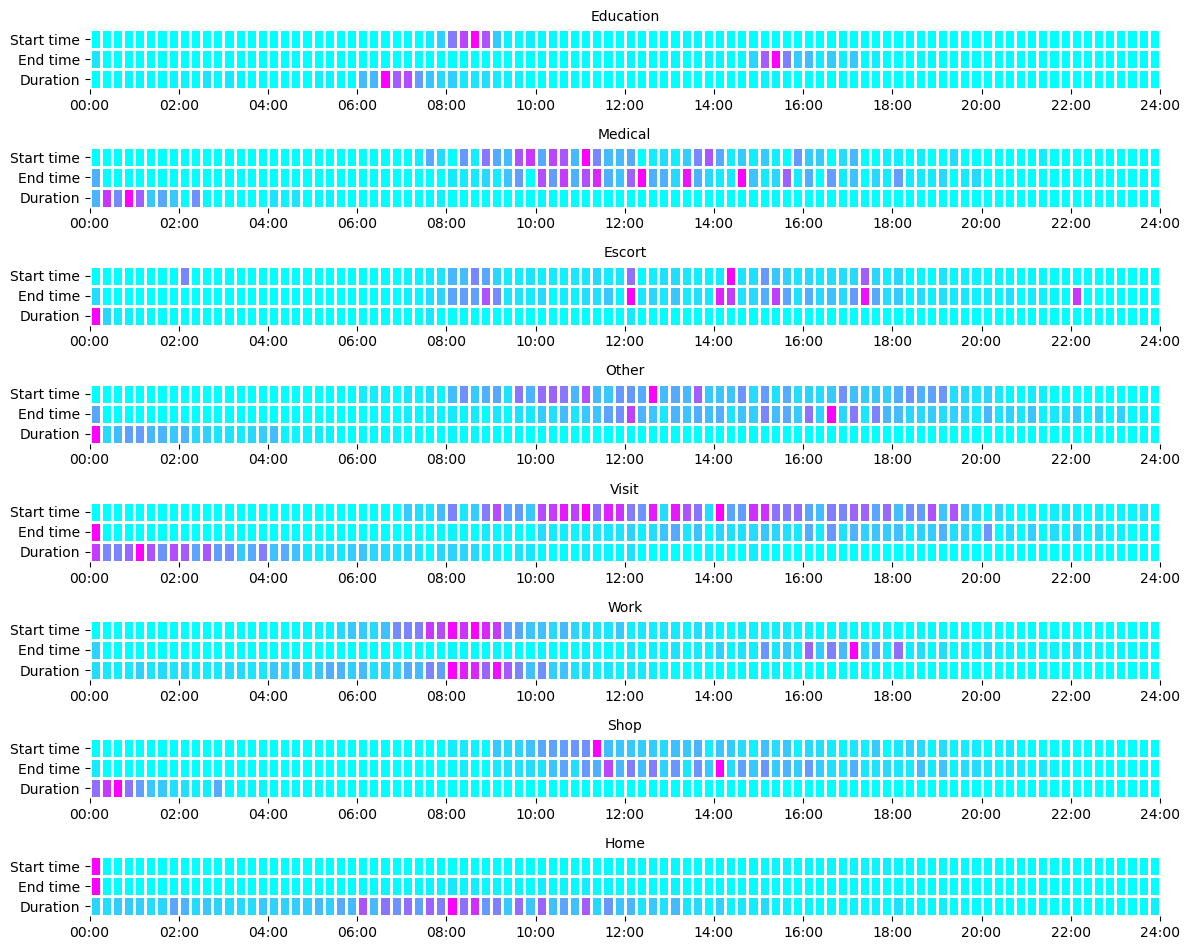

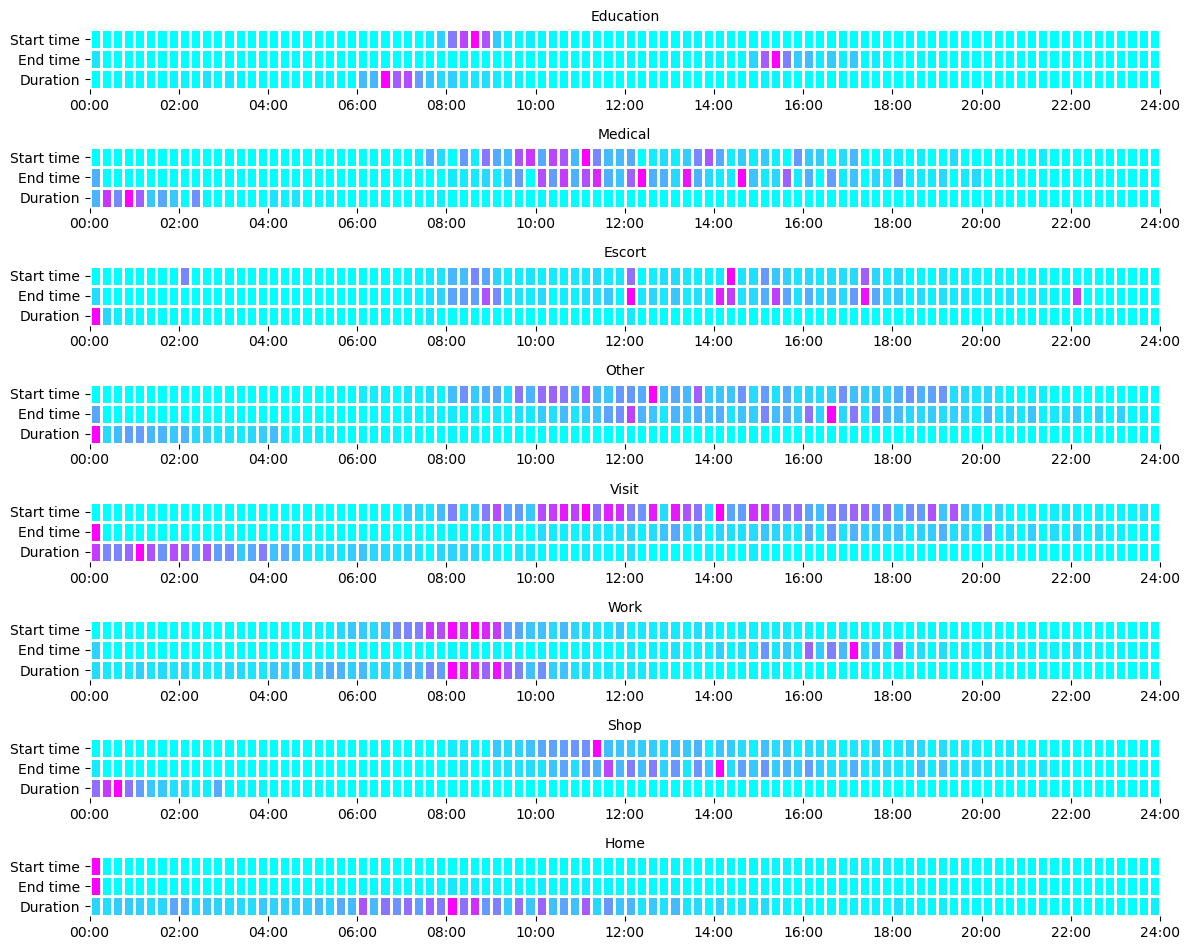

In [37]:
plot_activity_times(population)

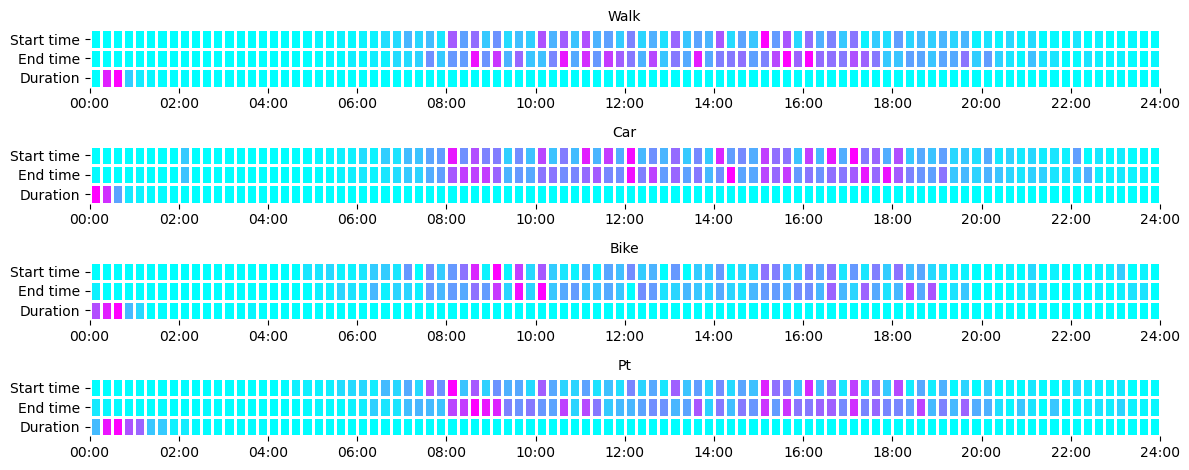

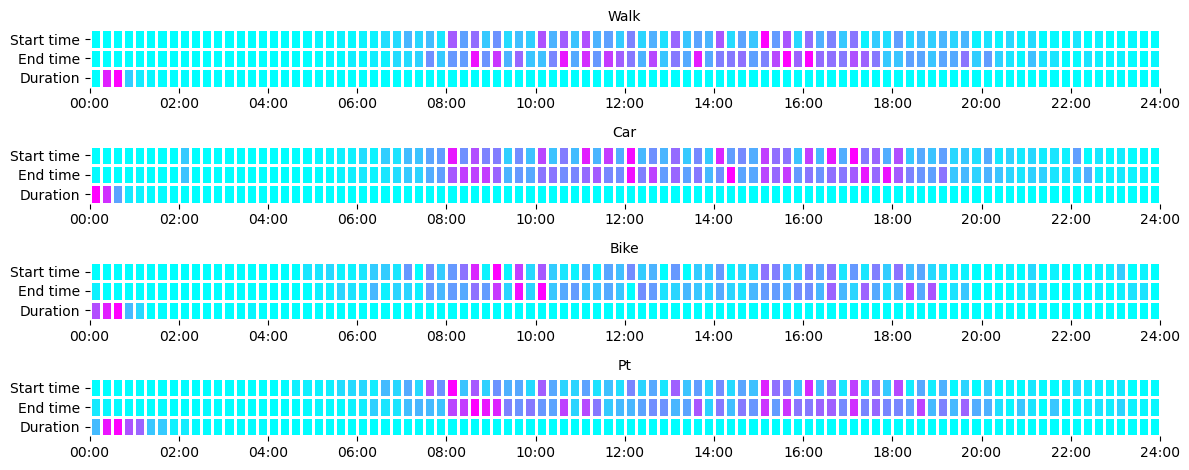

In [38]:
plot_leg_times(population)

## Matrices for OD Factory 

The PAM OD factory function needs the following matrices

- travel times (by mode)
- travel distances (this appears optional so I will ignore it for now)
- od_probs: probability of travelling between each pair of zones (by mode)

### Get data: Travel time matrices

In [43]:
travel_times = pd.read_parquet(
    acbm.root_path / "data/external/travel_times/oa/travel_time_matrix_acbm.parquet"
)

travel_times

,from_id,to_id,travel_time_p25,travel_time_p50,travel_time_p75,combination
0,53507,53507,0,0.0,0.0,pt_wkday_morning
1,53507,53508,24,29.0,34.0,pt_wkday_morning
2,53507,53509,17,22.0,27.0,pt_wkday_morning
3,53507,53510,12,14.0,16.0,pt_wkday_morning
4,53507,53511,14,16.0,18.0,pt_wkday_morning
...,...,...,...,...,...,...
36424170,175164,175158,52,52.0,52.0,cycle
36424171,175164,175160,13,13.0,13.0,cycle
36424172,175164,175161,90,90.0,90.0,cycle
36424173,175164,175163,15,15.0,15.0,cycle


#### Edit modes

We have travel times for PT by time of day. In discretionary trips, PAM needs the mode column to match the mode labels in ODFactory (see https://github.com/arup-group/pam/blob/main/examples/17_advanced_discretionary_locations.ipynb). We have two options

1. TODO: Preferred: Before reading the population into PAM, edit the mode column of the trips table to replace pt with pt_wkday_morning, pt_wkday_evening etc depending on day and time of trip. I dont know if this will work downstream
2. Simplify our travel time data. Use the same travel time regardless of time of day, and label as pt (to match with mode column)

I will do 2 for now

In [44]:
# keep only the rows that match specific "combination" values

modes_to_use = ['car', 'walk', 'cycle', 'pt_wkday_morning']

# Filter the DataFrame
travel_times = travel_times[travel_times['combination'].isin(modes_to_use)]

# Rename specific values in "combination" column
travel_times['combination'] = travel_times['combination'].replace({
    'cycle': 'bike',
    'pt_wkday_morning': 'pt'
})

/tmp/ipykernel_406306/2542162391.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_times['combination'] = travel_times['combination'].replace({


#### Add OA21CD

In [45]:
# convert from_id and to_id to int to match the boundaries data type
travel_times = travel_times.astype({"from_id": int, "to_id": int})

# merge travel_times with boundaries
travel_times = travel_times.merge(
    boundaries[["OBJECTID", "OA21CD"]],
    left_on="from_id",
    right_on="OBJECTID",
    how="left",
)
travel_times = travel_times.drop(columns="OBJECTID")

travel_times = travel_times.merge(
    boundaries[["OBJECTID", "OA21CD"]],
    left_on="to_id",
    right_on="OBJECTID",
    how="left",
    suffixes=("_from", "_to"),
)
travel_times = travel_times.drop(columns="OBJECTID")

travel_times.head(10)

,from_id,to_id,travel_time_p25,travel_time_p50,travel_time_p75,combination,OA21CD_from,OA21CD_to
0,53507,53507,0,0.0,0.0,pt,E00056750,E00056750
1,53507,53508,24,29.0,34.0,pt,E00056750,E00056751
2,53507,53509,17,22.0,27.0,pt,E00056750,E00056752
3,53507,53510,12,14.0,16.0,pt,E00056750,E00056753
4,53507,53511,14,16.0,18.0,pt,E00056750,E00056754
5,53507,53512,10,10.0,10.0,pt,E00056750,E00056755
6,53507,53513,11,13.0,15.0,pt,E00056750,E00056756
7,53507,53514,23,25.0,28.0,pt,E00056750,E00056757
8,53507,53515,31,36.0,41.0,pt,E00056750,E00056758
9,53507,53516,34,39.0,44.0,pt,E00056750,E00056759


### Get data: OD probabilities

We use the activities_per_zone data to calculate the OD probabilities

In [46]:
activities_per_zone = pd.read_parquet(
    acbm.root_path / "data/interim/assigning/activities_per_zone.parquet"
)

activities_per_zone.head(5)

,OA21CD,counts,floor_area,activity
0,E00056751,8,7552.0,work
1,E00056752,12,32255.0,work
2,E00056753,33,25607.0,work
3,E00056755,7,8647.0,work
4,E00056757,3,2058.0,work


In [47]:
# keep only rows that don't match primary activities
activities_per_zone = activities_per_zone[activities_per_zone["activity"].isin(["shop", "other", "medical", "visit"])]

# group by zone and get sum of counts and floor_area
activities_per_zone = activities_per_zone.groupby("OA21CD").agg({"counts": "sum", "floor_area": "sum"}).reset_index()
activities_per_zone.head(5)

,OA21CD,counts,floor_area
0,E00056751,1,1072.0
1,E00056752,2,1304.0
2,E00056753,36,31359.0
3,E00056755,4,3140.0
4,E00056761,9,6836.0


In [48]:
# Merge to get floor_area for origin
merged_df = travel_times.merge(activities_per_zone, left_on='OA21CD_to', right_on='OA21CD')

# Calculate the visit_probability: it is a funciton of floor_area and travel time
merged_df['visit_prob'] = np.where(merged_df['travel_time_p50'] != 0, 
                              round(merged_df['floor_area'] / np.sqrt(merged_df['travel_time_p50'])), 
                              round(merged_df['floor_area'])
                              )

merged_df

,from_id,to_id,travel_time_p25,travel_time_p50,travel_time_p75,combination,OA21CD_from,OA21CD_to,OA21CD,counts,floor_area,visit_prob
0,53507,53508,24,29.0,34.0,pt,E00056750,E00056751,E00056751,1,1072.0,199.0
1,53507,53509,17,22.0,27.0,pt,E00056750,E00056752,E00056752,2,1304.0,278.0
2,53507,53510,12,14.0,16.0,pt,E00056750,E00056753,E00056753,36,31359.0,8381.0
3,53507,53512,10,10.0,10.0,pt,E00056750,E00056755,E00056755,4,3140.0,993.0
4,53507,53518,23,28.0,33.0,pt,E00056750,E00056761,E00056761,9,6836.0,1292.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8127797,175164,175148,12,12.0,12.0,bike,E00187153,E00187137,E00187137,49,174153.0,50274.0
8127798,175164,175149,89,89.0,89.0,bike,E00187153,E00187138,E00187138,3,9124.0,967.0
8127799,175164,175153,68,68.0,68.0,bike,E00187153,E00187142,E00187142,9,32634.0,3957.0
8127800,175164,175155,11,11.0,11.0,bike,E00187153,E00187144,E00187144,5,7176.0,2164.0


### Create matrices

In [49]:
def create_od_matrices(
        df: pd.DataFrame, 
        mode_column: str, 
        value_column: str,
        zone_labels: tuple,
        fill_value: int,
        zone_from: str = 'OA21CD_from',
        zone_to: str = 'OA21CD_to',
        ) -> dict:
    
    """
    Create OD matrices for each mode in the DataFrame. This function is uused to create matrices for 
    - travel times
    - od_probs
    to be used in discretionary activity selection

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data
    mode_column : str
        Column name containing the mode of transport
    value_column : str
        Column name containing the value to be used in the OD matrix
    fill_value : int
        Value to use when a value for a specific od pair is not available

    Returns
    -------
    dict
        A dictionary containing OD matrices for each mode.
        Key: str
            Mode of transport
        Value: np.array
            OD matrix

    """
    
    # Initialize dictionaries to hold OD matrices for each combination type
    modes = df[mode_column].unique()
    od_matrices = {mode: np.full((len(zone_labels), len(zone_labels)), fill_value) for mode in modes}
    
    # Create a mapping from zone labels to indices
    zone_index = {label: idx for idx, label in enumerate(zone_labels)}
    
    # Vectorized operation to populate OD matrices
    from_indices = df[zone_from].map(zone_index)
    to_indices = df[zone_to].map(zone_index)
    
    for mode in modes:
        print(f"Starting mode: {mode}")
        mask = df[mode_column] == mode
        values = df[mask][value_column].fillna(fill_value)  # Fill missing values 
        od_matrices[mode][from_indices[mask], to_indices[mask]] = values
        print(f"Finished mode: {mode}")
    
    return od_matrices



In [50]:
# Extract unique zone labels. 
# TODO: get these from boundary/zone layer instead
zone_labels = pd.unique(travel_times[['OA21CD_from', 'OA21CD_to']].values.ravel('K'))
zone_labels = tuple(zone_labels)
print(zone_labels[:5])

('E00056750', 'E00056751', 'E00056752', 'E00056753', 'E00056754')


#### Create travel time matrices

In [51]:
matrix_travel_times = create_od_matrices(
    df = merged_df, 
    mode_column = 'combination', 
    value_column = 'travel_time_p50', 
    zone_labels = zone_labels,
    fill_value = 300,  # replace missing travel times with 6 hours (they are unreachable)
    zone_from='OA21CD_from', 
    zone_to='OA21CD_to'
    )

Starting mode: pt
Finished mode: pt
Starting mode: car
Finished mode: car
Starting mode: walk
Finished mode: walk
Starting mode: bike
Finished mode: bike


In [52]:
matrix_travel_times["car"][100:110, 100:110]

array([[  0,   2, 300, 300,   4,   6, 300,   4, 300, 300],
       [  2,   0, 300, 300,   6,   8, 300,   7, 300, 300],
       [  5,   6, 300, 300,   4,   6, 300,   6, 300, 300],
       [  4,   6, 300, 300,   3,   6, 300,   5, 300, 300],
       [  3,   5, 300, 300,   0,   5, 300,   4, 300, 300],
       [  5,   8, 300, 300,   6,   0, 300,   3, 300, 300],
       [  6,   6, 300, 300,   5,   7, 300,   6, 300, 300],
       [  4,   6, 300, 300,   4,   4, 300,   0, 300, 300],
       [  8,  11, 300, 300,   7,   7, 300,   3, 300, 300],
       [  4,   6, 300, 300,   4,   5, 300,   1, 300, 300]])

#### Create od probs matrices

In [53]:
matrix_od_probs = create_od_matrices(
    df = merged_df, 
    mode_column = 'combination', 
    value_column = 'visit_prob', 
    zone_labels = zone_labels,
    # replace missing probabilities with 1. There are no activities so shouldn't be visited
    # 1 used instead of 0 to avoid (ValueError: Total of weights must be finite) in weighted sampling 
    # (https://github.com/arup-group/pam/blob/c8bff760fbf92f93f95ff90e4e2af7bbe107c7e3/src/pam/planner/utils_planner.py#L17)
    fill_value = 1,  
    zone_from='OA21CD_from', 
    zone_to='OA21CD_to'
    )

Starting mode: pt
Finished mode: pt
Starting mode: car
Finished mode: car
Starting mode: walk
Finished mode: walk
Starting mode: bike
Finished mode: bike


In [54]:
#matrix_od_probs["walk"][100:110, 100:110]
matrix_od_probs["walk"][0:10, 0:10]


array([[    1,     1,     1,     1,     1,   993,     1,     1,     1,
            1],
       [    1,  1072,     1,     1,     1,     1,     1,     1,     1,
            1],
       [    1,     1,  1304,     1,     1,     1,     1,     1,     1,
            1],
       [    1,     1,     1, 31359,     1,     1,     1,     1,     1,
            1],
       [    1,     1,     1, 12802,     1,     1,     1,     1,     1,
            1],
       [    1,     1,     1,     1,     1,  3140,     1,     1,     1,
            1],
       [    1,     1,     1, 10453,     1,  1110,     1,     1,     1,
            1],
       [    1,     1,     1,     1,     1,     1,     1,     1,     1,
            1],
       [    1,     1,     1,     1,     1,     1,     1,     1,     1,
            1],
       [    1,     1,     1,     1,     1,     1,     1,     1,     1,
            1]])

#### Create ODMatrix objects

In [55]:
mode_types = travel_times['combination'].unique()

In [56]:
matrices_pam_travel_time = [
    ODMatrix("time", mode, zone_labels, zone_labels, matrix_travel_times[mode])
    for mode in mode_types
]

In [57]:
matrices_pam_travel_time[1]

ODMatrix(var='time', mode='car', origin_zones=('E00056750', 'E00056751', 'E00056752', 'E00056753', 'E00056754', 'E00056755', 'E00056756', 'E00056757', 'E00056758', 'E00056759', 'E00056760', 'E00056761', 'E00056762', 'E00056763', 'E00056764', 'E00056765', 'E00056766', 'E00056767', 'E00056768', 'E00056769', 'E00056770', 'E00056771', 'E00056772', 'E00056773', 'E00056774', 'E00056775', 'E00056776', 'E00056777', 'E00056778', 'E00056779', 'E00056780', 'E00056781', 'E00056782', 'E00056783', 'E00056784', 'E00056787', 'E00056788', 'E00056789', 'E00056790', 'E00056792', 'E00056793', 'E00056794', 'E00056795', 'E00056796', 'E00056797', 'E00056798', 'E00056799', 'E00056800', 'E00056801', 'E00056802', 'E00056803', 'E00056804', 'E00056805', 'E00056806', 'E00056807', 'E00056808', 'E00056809', 'E00056810', 'E00056811', 'E00056812', 'E00056813', 'E00056814', 'E00056815', 'E00056816', 'E00056817', 'E00056818', 'E00056819', 'E00056820', 'E00056821', 'E00056822', 'E00056823', 'E00056825', 'E00056827', 'E00

In [58]:
matrices_pam_od_probs = [
    ODMatrix("od_probs", mode, zone_labels, zone_labels, matrix_od_probs[mode])
    for mode in mode_types
]

#### Create ODFactory object 

In [59]:
# combine ODMatrix objects
matrices_pam_all = matrices_pam_travel_time + matrices_pam_od_probs
matrices_pam_all

[ODMatrix(var='time', mode='pt', origin_zones=('E00056750', 'E00056751', 'E00056752', 'E00056753', 'E00056754', 'E00056755', 'E00056756', 'E00056757', 'E00056758', 'E00056759', 'E00056760', 'E00056761', 'E00056762', 'E00056763', 'E00056764', 'E00056765', 'E00056766', 'E00056767', 'E00056768', 'E00056769', 'E00056770', 'E00056771', 'E00056772', 'E00056773', 'E00056774', 'E00056775', 'E00056776', 'E00056777', 'E00056778', 'E00056779', 'E00056780', 'E00056781', 'E00056782', 'E00056783', 'E00056784', 'E00056787', 'E00056788', 'E00056789', 'E00056790', 'E00056792', 'E00056793', 'E00056794', 'E00056795', 'E00056796', 'E00056797', 'E00056798', 'E00056799', 'E00056800', 'E00056801', 'E00056802', 'E00056803', 'E00056804', 'E00056805', 'E00056806', 'E00056807', 'E00056808', 'E00056809', 'E00056810', 'E00056811', 'E00056812', 'E00056813', 'E00056814', 'E00056815', 'E00056816', 'E00056817', 'E00056818', 'E00056819', 'E00056820', 'E00056821', 'E00056822', 'E00056823', 'E00056825', 'E00056827', 'E00

In [60]:
#create ODFactory
od = ODFactory.from_matrices(matrices = matrices_pam_all)


In [61]:
od

Origin-destination dataset 
--------------------------------------------------
Labels(vars=['time', 'od_probs'], origin_zones=('E00056750', 'E00056751', 'E00056752', 'E00056753', 'E00056754', 'E00056755', 'E00056756', 'E00056757', 'E00056758', 'E00056759', 'E00056760', 'E00056761', 'E00056762', 'E00056763', 'E00056764', 'E00056765', 'E00056766', 'E00056767', 'E00056768', 'E00056769', 'E00056770', 'E00056771', 'E00056772', 'E00056773', 'E00056774', 'E00056775', 'E00056776', 'E00056777', 'E00056778', 'E00056779', 'E00056780', 'E00056781', 'E00056782', 'E00056783', 'E00056784', 'E00056787', 'E00056788', 'E00056789', 'E00056790', 'E00056792', 'E00056793', 'E00056794', 'E00056795', 'E00056796', 'E00056797', 'E00056798', 'E00056799', 'E00056800', 'E00056801', 'E00056802', 'E00056803', 'E00056804', 'E00056805', 'E00056806', 'E00056807', 'E00056808', 'E00056809', 'E00056810', 'E00056811', 'E00056812', 'E00056813', 'E00056814', 'E00056815', 'E00056816', 'E00056817', 'E00056818', 'E00056819', 'E

### Discretionary activities

Test the implementation of discretionary activities

In [62]:
def print_activity_locs(plan):
    summary = PrettyTable(["seq", "purpose", "location"])
    for seq, act in enumerate(plan.activities):
        summary.add_row([seq, act.act, act.location.area])
    print(summary)

In [191]:
import random

plans_iterator = population.plans()
all_plans = list(plans_iterator)


random_plan = random.choice(all_plans)
print_activity_locs(random_plan)

+-----+---------+-----------+
| seq | purpose |  location |
+-----+---------+-----------+
|  0  |   home  | E00058503 |
|  1  |  other  |    None   |
|  2  |   home  | E00058503 |
+-----+---------+-----------+


In [184]:
random_plan_copy = deepcopy(random_plan)
planner = DiscretionaryTrips(plan=random_plan_copy, od=od)
planner.update_plan()

print_activity_locs(random_plan_copy)

+-----+---------+-----------+
| seq | purpose |  location |
+-----+---------+-----------+
|  0  |   home  | E00058952 |
|  1  |  other  | E00057069 |
|  2  |   home  | E00058952 |
|  3  |  other  | E00058837 |
|  4  |   home  | E00058952 |
+-----+---------+-----------+


Apply logic to entire population

In [143]:
# i = 1
# for plan in population2.plans():
#     planner = DiscretionaryTrips(plan=plan, od=od)
#     planner.update_plan()
#     print(f"Plan {i}: {plan_new}")
#     i += 1

i = 1
for plan in population2.plans():
    try:
        planner = DiscretionaryTrips(plan=plan, od=od)
        planner.update_plan()
        print(f"Plan {i}: {plan_new}")
    except Exception as e:
        print(f"An error occurred with plan {i}: {e}")
    i += 1
    

Plan 1: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 2: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 3: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 4: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 6: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 7: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 8: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 9: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 10: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 11: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 12: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 13: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 14: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 15: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 16: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 17: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 18: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 19: <pam.activity.Plan object at

/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/planner/choice_location.py:423: RuntimeWarning: invalid value encountered in divide
  leg_ratio = imp_first_leg / (imp_first_leg + imp_second_leg)
/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/planner/choice_location.py:454: RuntimeWarning: divide by zero encountered in divide
  diversion_factors = imp_tour / imp_direct
/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/planner/choice_location.py:454: RuntimeWarning: invalid value encountered in divide
  diversion_factors = imp_tour / imp_direct
/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/planner/choice_location.py:485: RuntimeWarning: invalid value encountered in divide
  p /= p.sum()


Plan 585: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 586: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 587: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 588: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 589: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 590: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 591: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 592: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 593: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 594: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 595: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 596: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 597: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 598: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 599: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 600: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 601: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 602: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 603: 

In [186]:
for plan in population2.plans():
    try:
        planner = DiscretionaryTrips(plan=plan, od=od)
        planner.update_plan()
        print(f"Plan {i}: {plan_new}")
    except Exception as e:
        print(f"An error occurred with plan {plan.pid}: {e}")
    i += 1

Plan 5358: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5359: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5360: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5361: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5362: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5363: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5364: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5365: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5366: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5367: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5368: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5369: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5370: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5371: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5372: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5373: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5374: <pam.activity.Plan object at 0x7e4acfd3cc10>
Plan 5375: <pam.activity.Plan object at 0x7e4acf

/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/planner/choice_location.py:423: RuntimeWarning: invalid value encountered in divide
  leg_ratio = imp_first_leg / (imp_first_leg + imp_second_leg)
/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/planner/choice_location.py:454: RuntimeWarning: divide by zero encountered in divide
  diversion_factors = imp_tour / imp_direct
/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/planner/choice_location.py:454: RuntimeWarning: invalid value encountered in divide
  diversion_factors = imp_tour / imp_direct


AttributeError: 'Plan' object has no attribute 'pid'

Save

In [185]:
write.to_csv(population2, dir=(
    acbm.root_path / "data/processed/activities_pam"
))

2024-08-23 10:44:28,777 - WARNING - Missing person weight in hh 89, returning None.
2024-08-23 10:44:28,778 - WARNING - Missing person weight in hh 139, returning None.
2024-08-23 10:44:28,778 - WARNING - Missing person weight in hh 197, returning None.
2024-08-23 10:44:28,779 - WARNING - Missing person weight in hh 283, returning None.
2024-08-23 10:44:28,779 - WARNING - Missing person weight in hh 342, returning None.
2024-08-23 10:44:28,780 - WARNING - Missing person weight in hh 371, returning None.
2024-08-23 10:44:28,780 - WARNING - Missing person weight in hh 621, returning None.
2024-08-23 10:44:28,781 - WARNING - Missing person weight in hh 645, returning None.
2024-08-23 10:44:28,781 - WARNING - Missing person weight in hh 892, returning None.
2024-08-23 10:44:28,782 - WARNING - Missing person weight in hh 1156, returning None.
2024-08-23 10:44:28,783 - WARNING - Missing person weight in hh 1159, returning None.
2024-08-23 10:44:28,783 - WARNING - Missing person weight in hh 

In [190]:
write.write_matsim(population2, plans_path= 
                   acbm.root_path / "data/processed/activities_pam.xml")


InvalidMATSimError: Activity requires link id or x,y coordinates.

In [137]:
i = 1
for hid, pid, person in population.people():
    print(f"index {i}: {hid} - {pid} - {person}")
    i += 1

index 1: 89 - 199 - Person: 199
index 2: 89 - 200 - Person: 200
index 3: 89 - 201 - Person: 201
index 4: 139 - 312 - Person: 312
index 5: 139 - 313 - Person: 313
index 6: 197 - 425 - Person: 425
index 7: 283 - 611 - Person: 611
index 8: 283 - 612 - Person: 612
index 9: 283 - 613 - Person: 613
index 10: 342 - 743 - Person: 743
index 11: 371 - 806 - Person: 806
index 12: 371 - 807 - Person: 807
index 13: 371 - 808 - Person: 808
index 14: 621 - 1334 - Person: 1334
index 15: 645 - 1385 - Person: 1385
index 16: 645 - 1386 - Person: 1386
index 17: 645 - 1387 - Person: 1387
index 18: 892 - 2016 - Person: 2016
index 19: 1156 - 2561 - Person: 2561
index 20: 1159 - 2567 - Person: 2567
index 21: 1178 - 2598 - Person: 2598
index 22: 1178 - 2599 - Person: 2599
index 23: 1330 - 2917 - Person: 2917
index 24: 1330 - 2918 - Person: 2918
index 25: 1577 - 3443 - Person: 3443
index 26: 1577 - 3444 - Person: 3444
index 27: 1687 - 3675 - Person: 3675
index 28: 1687 - 3676 - Person: 3676
index 29: 1773 - 385

In [138]:
activity_chains_all[activity_chains_all["id"] == 20194]

# activity_chains_all[activity_chains_all["household"] == 8999]

# 8999 - 20194 - Person: 20194

,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,ozone,dzone,origin_id,origin_geom,activity_id,activity_geom,hzone
393,20194,8999,2019002438,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",30,home,work,60.0,8.7,1.0,pt,349.0,409.0,E00058366,E00058366,175664198,POINT (-1.68403 53.89987),175664210,POINT (-1.68807515880873 53.90087907266629),E00058366
394,20194,8999,2019002438,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",30,work,other,51.0,7.9,2.0,pt,988.0,1039.0,E00058366,NaN,175664210,POINT (-1.68808 53.90088),NaN,NaN,E00058366
395,20194,8999,2019002438,"[2019002278.0, 2019002297.0, 2019002293.0, 201...",30,other,home,10.0,1.1,3.0,pt,1175.0,1185.0,NaN,E00058366,None,None,175664198,POINT (-1.684033337089878 53.89987244746859),E00058366


In [ ]:
random_plan = random.choice(all_plans2)

print_activity_locs(random_plan)

In [140]:
#x = matrix_travel_times["pt"]

def check_matrix_values(matrix):
    if np.isnan(matrix).any():
        print("The matrix contains NaN values.")
    if not np.isfinite(matrix).all():
        print("The matrix contains inf or -inf values.")
    if np.isfinite(matrix).all() and not np.isnan(matrix).any():
        print("The matrix does not contain NaN, inf, or -inf values.")

# Example usage with a DataFrame
# Assuming `travel_times` is your DataFrame and you want to check a specific column
check_matrix_values(matrix_od_probs["bike"])


The matrix does not contain NaN, inf, or -inf values.


In [142]:
(
    np.isfinite(matrix_od_probs["walk"]).all() and not np.isnan(matrix_od_probs["walk"]).any(),
    np.isfinite(matrix_od_probs["bike"]).all() and not np.isnan(matrix_od_probs["bike"]).any(),
    np.isfinite(matrix_od_probs["pt"]).all() and not np.isnan(matrix_od_probs["pt"]).any(),
    np.isfinite(matrix_od_probs["car"]).all() and not np.isnan(matrix_od_probs["car"]).any()
)

(True, True, True, True)